In [1]:
import numpy as np 
import pandas as pd 
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_DIR = "UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        return None, None, None

In [4]:
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))

In [5]:
attributes = list(map(parse_filepath, files))
attributes[0]

(100, 'male', 'white')

In [6]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,100.0,male,white,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1,100.0,male,white,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2,100.0,female,white,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3,100.0,female,white,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4,100.0,female,white,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg


In [7]:
df = df[(df['age'] > 10) & (df['age'] < 65)]

In [8]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(9079, 3891, 5559, 64.0)

In [11]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

In [14]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

def conv_block(inp, filters=32, bn=True, pool=True):
    _ = Conv2D(filters=filters, kernel_size=3, activation='relu')(inp)
    if bn:
        _ = BatchNormalization()(_)
    if pool:
        _ = MaxPool2D()(_)
    return _

input_layer = Input(shape=(IM_HEIGHT, IM_WIDTH, 3))
_ = conv_block(input_layer, filters=32, bn=False, pool=False)
_ = conv_block(_, filters=32*2)
_ = conv_block(_, filters=32*3)
_ = conv_block(_, filters=32*4)
_ = conv_block(_, filters=32*5)
_ = conv_block(_, filters=32*6)
bottleneck = GlobalMaxPool2D()(_)

# for age calculation
_ = Dense(units=128, activation='relu')(bottleneck)
age_output = Dense(units=1, activation='sigmoid', name='age_output')(_)

# for race prediction
_ = Dense(units=128, activation='relu')(bottleneck)
race_output = Dense(units=len(RACE_ID_MAP), activation='softmax', name='race_output')(_)

# for gender prediction
_ = Dense(units=128, activation='relu')(bottleneck)
gender_output = Dense(units=len(GENDER_ID_MAP), activation='softmax', name='gender_output')(_)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={'age_output': 'mse', 'race_output': 'categorical_crossentropy', 'gender_output': 'categorical_crossentropy'},
              loss_weights={'age_output': 2., 'race_output': 1.5, 'gender_output': 1.},
              metrics={'age_output': 'mae', 'race_output': 'accuracy', 'gender_output': 'accuracy'})

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=2,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/2
141/141 [==============================] - ETA: 0s - loss: 2.9171 - age_output_loss: 0.0667 - race_output_loss: 1.4113 - gender_output_loss: 0.6668 - age_output_mae: 0.2067 - race_output_accuracy: 0.4864 - gender_output_accuracy: 0.7041

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


141/141 [==============================] - 910s 6s/step - loss: 2.9171 - age_output_loss: 0.0667 - race_output_loss: 1.4113 - gender_output_loss: 0.6668 - age_output_mae: 0.2067 - race_output_accuracy: 0.4864 - gender_output_accuracy: 0.7041 - val_loss: 4.2542 - val_age_output_loss: 0.0615 - val_race_output_loss: 1.9930 - val_gender_output_loss: 1.1419 - val_age_output_mae: 0.2192 - val_race_output_accuracy: 0.3917 - val_gender_output_accuracy: 0.5128
Epoch 2/2
141/141 [==============================] - ETA: 0s - loss: 1.9233 - age_output_loss: 0.0386 - race_output_loss: 0.9950 - gender_output_loss: 0.3537 - age_output_mae: 0.1572 - race_output_accuracy: 0.6316 - gender_output_accuracy: 0.8490

INFO:tensorflow:Assets written to: .\model_checkpoint\assets


INFO:tensorflow:Assets written to: .\model_checkpoint\assets


141/141 [==============================] - 885s 6s/step - loss: 1.9233 - age_output_loss: 0.0386 - race_output_loss: 0.9950 - gender_output_loss: 0.3537 - age_output_mae: 0.1572 - race_output_accuracy: 0.6316 - gender_output_accuracy: 0.8490 - val_loss: 2.5960 - val_age_output_loss: 0.0511 - val_race_output_loss: 1.2014 - val_gender_output_loss: 0.6916 - val_age_output_mae: 0.1920 - val_race_output_accuracy: 0.5750 - val_gender_output_accuracy: 0.6518


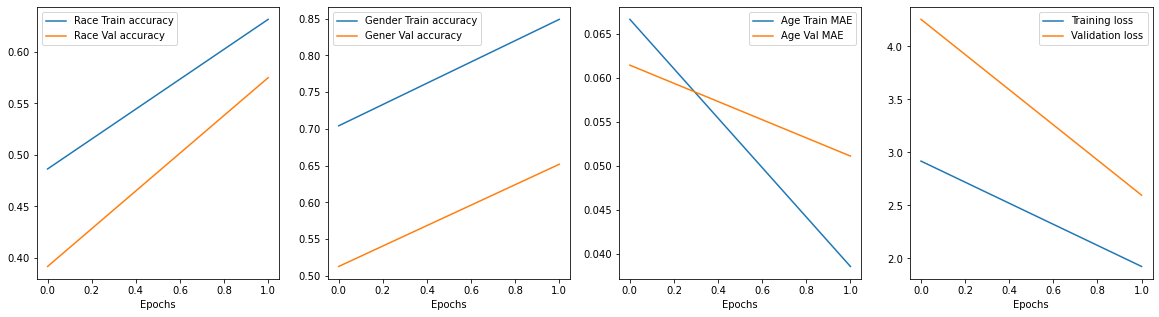

In [16]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_loss'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_loss'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

### Evaluation

In [17]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate_generator(test_gen, steps=len(test_idx)//128)))

{'loss': 2.5337843894958496,
 'age_output_loss': 0.04939013347029686,
 'race_output_loss': 1.161689043045044,
 'gender_output_loss': 0.6924707889556885,
 'age_output_mae': 0.1886938512325287,
 'race_output_accuracy': 0.5764898061752319,
 'gender_output_accuracy': 0.6580668687820435}

In [18]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

In [19]:
race_true, gender_true = race_true.argmax(axis=-1), gender_true.argmax(axis=-1)
race_pred, gender_pred = race_pred.argmax(axis=-1), gender_pred.argmax(axis=-1)
age_true = age_true * max_age
age_pred = age_pred * max_age

In [20]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred))

Classification report for race
              precision    recall  f1-score   support

           0       0.56      0.69      0.62        49
           1       0.69      0.38      0.49        29
           2       0.69      0.53      0.60        17
           3       0.34      0.62      0.44        21
           4       0.00      0.00      0.00        12

    accuracy                           0.52       128
   macro avg       0.46      0.44      0.43       128
weighted avg       0.52      0.52      0.50       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        68
           1       1.00      0.28      0.44        60

    accuracy                           0.66       128
   macro avg       0.81      0.64      0.60       128
weighted avg       0.79      0.66      0.61       128

